In [ ]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import os

In [ ]:
import torch
x = torch.rand(5, 3)
print(x)

In [ ]:
torch.cuda.is_available()

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

CustomHandDetectionModel:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ObjectDetectionCNN(nn.Module):
    def __init__(self):
        super(ObjectDetectionCNN, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.fc1 = nn.Linear(32 * 64 * 64, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 4)  # 4 values for (xmin, ymin, xmax, ymax)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x


model = ObjectDetectionCNN()

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


dummy_images = torch.randn(10, 3, 128, 128)  
dummy_bounding_boxes = torch.randn(10, 4)  

num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(dummy_images)
    loss = criterion(predictions, dummy_bounding_boxes)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')




CustomGestureClassificationModel:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

class CustomObjectClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomObjectClassifier, self).__init__()
        

        self.resize = transforms.Resize((128, 128))
        

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        

        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, image, bounding_box):
        
        xmin, ymin, xmax, ymax = bounding_box
        cropped_image = image[:, :, ymin:ymax, xmin:xmax]
        
        
        resized_image = self.resize(cropped_image)
        
        
        features = self.cnn(resized_image)
        
        
        features = features.view(features.size(0), -1)
        
        
        output = self.fc(features)
        
        return output


model = CustomObjectClassifier(num_classes=3)


criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=0.001)


dummy_images = torch.randn(10, 3, 128, 128)
dummy_bounding_boxes = torch.randint(0, 128, (10, 4))  


dummy_labels = torch.randint(0, 3, (10,))


num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(dummy_images, dummy_bounding_boxes)
    loss = criterion(predictions, dummy_labels)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')




dataloading techniques

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class DataFrame(Dataset):
    def __init__(self, data_dir, csv_file, transform=None):
        self.data_dir = data_dir
        self.data_df = pd.read_csv(csv_file)
        self.transform = transform
        self.class_mapping = {"Rock": 0, "Paper": 1, "Scissors": 2}

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.data_df.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        
        # Get image dimensions
        width, height = int(self.data_df.iloc[idx, 1]), int(self.data_df.iloc[idx, 2])

        # Get object class
        object_class = self.data_df.iloc[idx, 3]
        class_label = self.class_mapping.get(object_class, -1)
        
        # Get bounding box coordinates
        x_min, y_min, x_max, y_max = (
            int(self.data_df.iloc[idx, 4]),
            int(self.data_df.iloc[idx, 5]),
            int(self.data_df.iloc[idx, 6]),
            int(self.data_df.iloc[idx, 7]),
        )
        
        sample = {
            "image": image,
            "width": width,
            "height": height,
            "bbox": [x_min, y_min, x_max, y_max],
            "class": class_label,
        }

        if self.transform:
            sample["image"] = self.transform(sample["image"])

        return sample


train_dir = r"C:\Users\ashis\OneDrive\Desktop\CS\ai_ml\Rock Paper Scissors SXSW.v12i.tensorflow\train"
csv_train_file = r"C:\Users\ashis\OneDrive\Desktop\CS\ai_ml\Rock Paper Scissors SXSW.v12i.tensorflow\train\_annotations.csv"

val_dir = r"C:\Users\ashis\OneDrive\Desktop\CS\ai_ml\Rock Paper Scissors SXSW.v12i.tensorflow\valid"
csv_val_file = r"C:\Users\ashis\OneDrive\Desktop\CS\ai_ml\Rock Paper Scissors SXSW.v12i.tensorflow\valid\_annotations.csv"

transform = transforms.Compose([transforms.Resize((640, 640)), transforms.ToTensor()])
Train = DataFrame(data_dir=train_dir, csv_file=csv_train_file, transform=transform)
Val = DataFrame(data_dir=val_dir, csv_file=csv_val_file, transform=transform)


batch_size = 32
train_dl = torch.utils.data.DataLoader(Train, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(Val, batch_size=batch_size*2, shuffle=True)

displaying the images

In [ ]:
import matplotlib.pyplot as plt

# Iterate through the dataset and display images with their classes
for sample in Train:
    image = sample["image"]
    object_class = sample["class"]
    if (object_class = 0)
        r+=1
    
    # Convert the PyTorch tensor to a NumPy array for display
    image = image.permute(1, 2, 0).numpy()
    
    # Display the image
    plt.imshow(image)
    plt.title(f"Class: {object_class}")
    plt.axis('off')
    plt.show()
    


to view one batch as a grid

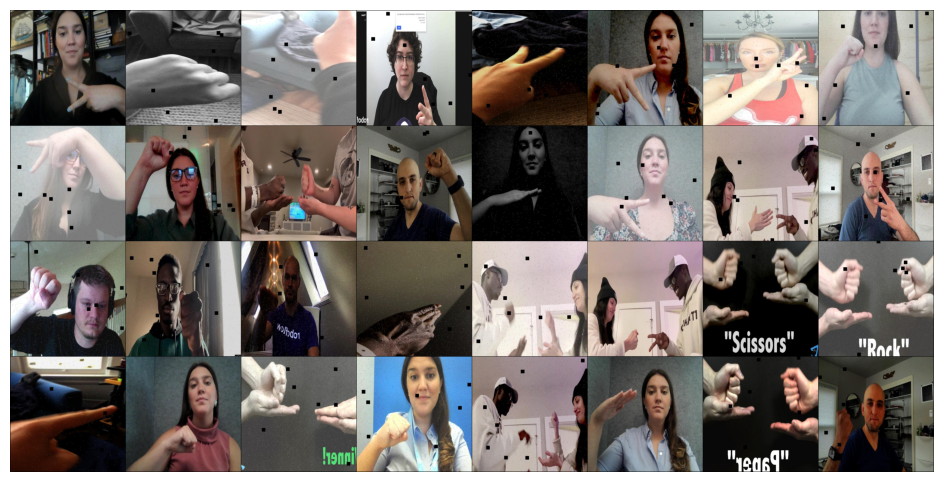

In [60]:
from torchvision.utils import make_grid
def show_batch(df):
    for sample in df:
        fig, ax = plt.subplots(figsize = (12,6))
        ax.set_xticks([]);ax.set_xticks([])
        ax.imshow(make_grid(sample["image"], nrow = 8).permute(1,2,0))
        plt.axis('off')
        break

show_batch(train_dl)


alternate dataloading strategy just in case

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import os

for i in range(0,7821):
    data.iloc[i] = data.iloc[i].to_numpy()

data.iloc[100][0]

folder_path = r"C:\Users\ashis\OneDrive\Desktop\CS\ai_ml\Rock Paper Scissors SXSW.v12i.tensorflow\train"
image_filename = data.iloc[100][0]


image_path = os.path.join(folder_path, image_filename)

image = Image.open(image_path)

transform = transforms.ToTensor()
tensor_image = transform(image)

plt.imshow(tensor_image.permute(2, 1, 0)) 
plt.axis('off')  
plt.show()
